# Skin Lesion Classification using Machine Learning
This project aims to classify skin lesions as **malignant** or **benign** using deep learning techniques on the **ISIC 2020 Challenge dataset**. The final model will be considered for integration into a mobile application.

## Objectives
- Preprocess and analyze the ISIC 2020 dataset
- Train a convolutional neural network
- Evaluate the model using appropriate metrics
- Prepare the model for mobile deployment


In [87]:
# Toggle fast mode ON for quick testing or OFF for full functionality
# Set to True for fast mode, False for full functionality
FAST_MODE = True


In [88]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from focal_loss import BinaryFocalLoss


print("Modules Installed Succsessfully")
print("Tensorflow Version: ", tf.__version__)

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)



Modules Installed Succsessfully
Tensorflow Version:  2.19.0
Available GPUs: []


In [89]:
from tensorflow.python.platform import build_info as tf_build_info
print("TF Build Info:", tf_build_info.build_info)


TF Build Info: OrderedDict({'is_cuda_build': False, 'is_rocm_build': False, 'is_tensorrt_build': False, 'msvcp_dll_names': 'msvcp140.dll,msvcp140_1.dll'})


In [90]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Detected GPUs:", gpus)

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print("Error enabling memory growth:", e)
else:
    print("⚠️ No GPU detected by TensorFlow")


Detected GPUs: []
⚠️ No GPU detected by TensorFlow


## Dataset Preparation

We load the metadata from the ISIC 2020 competition and associate each image with a binary label:
- `0` = Benign
- `1` = Malignant


In [91]:
CSV_PATH = '../data/train.csv'
IMAGE_DIR = '../data/jpeg/train'

df = pd.read_csv(CSV_PATH)
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(IMAGE_DIR, f"{x}.jpg"))
df['label'] = df['target'].apply(lambda x: 'malignant' if x == 1 else 'benign')
df.head(10)

df['label'].value_counts()



label
benign       32542
malignant      584
Name: count, dtype: int64

## Class Distribution

The dataset is imbalanced, with far more benign cases than malignant. We'll use data augmentation to help mitigate this.


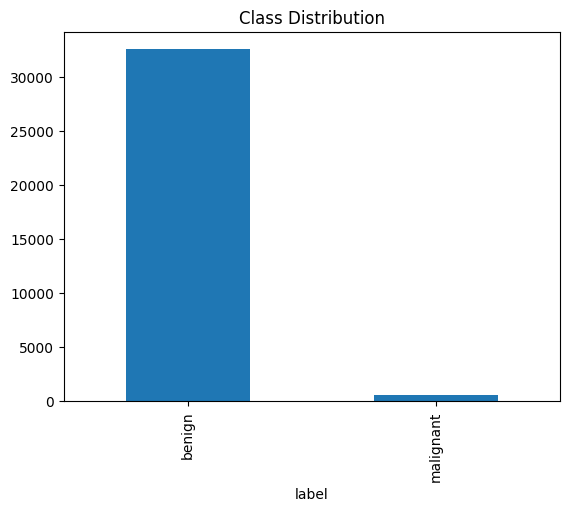

In [92]:
df['label'].value_counts().plot(kind='bar', title='Class Distribution');


## Data Augmentation and Preprocessing

We split the dataset into training and validation sets, and apply augmentation to the training data to improve generalization.

#-> Serious Class imabalnces

In [93]:
# if FAST_MODE:
#     # Sample a small subset for faster testing
#     df_small, _ = train_test_split(df, train_size=2000, stratify=df['label'], random_state=42)
#     train_df, val_df = train_test_split(df_small, test_size=0.2, stratify=df_small['label'], random_state=42)
#     print("⚡ FAST_MODE enabled: Using 2,000 samples.")
# else:
#     train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
#     print("✅ FAST_MODE disabled: Using full dataset.")

if FAST_MODE:
    # Sample a small subset for faster testing
    df_small, _ = train_test_split(df, train_size=2000, stratify=df['label'], random_state=42)
    train_df, val_df = train_test_split(df_small, test_size=0.2, stratify=df_small['label'], random_state=42)
    print("⚡ FAST_MODE enabled: Using 2,000 samples.")

else:
    # Full dataset split
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    print("✅ FAST_MODE disabled: Using full dataset.")

# --- Oversample (for BOTH modes) ---
benign_df = train_df[train_df['label'] == 'benign']
malignant_df = train_df[train_df['label'] == 'malignant']

# Oversample malignant to match benign count
malignant_oversampled = malignant_df.sample(n=len(benign_df), replace=True, random_state=42)

# Combine and shuffle
train_df = pd.concat([benign_df, malignant_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Print result
print("\nBalanced Training Set:")
print(train_df['label'].value_counts())

print("\nValidation Set:")
print(val_df['label'].value_counts())



⚡ FAST_MODE enabled: Using 2,000 samples.

Balanced Training Set:
label
malignant    1572
benign       1572
Name: count, dtype: int64

Validation Set:
label
benign       393
malignant      7
Name: count, dtype: int64


In [94]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)


val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

train_df['label'].value_counts()



Found 3144 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


label
malignant    1572
benign       1572
Name: count, dtype: int64

## Model Performance Visualization

To better understand how each model learns over time, we plot both:
- Training vs. Validation **Accuracy**
- Training vs. Validation **Loss**

This helps us diagnose issues like overfitting or underfitting.

In [95]:
# def plot_training_history(history, model_name="Model"):
#     epochs = range(1, len(history.history['accuracy']) + 1)
#     num_subplots = 4 if 'auc' in history.history else 3

#     plt.figure(figsize=(16, 12))

#     # Accuracy
#     plt.subplot(2, 2, 1)
#     plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
#     plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy')
#     plt.title(f'{model_name} - Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Loss
#     plt.subplot(2, 2, 2)
#     plt.plot(epochs, history.history['loss'], label='Train Loss')
#     plt.plot(epochs, history.history['val_loss'], label='Val Loss')
#     plt.title(f'{model_name} - Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Precision
#     if 'precision' in history.history:
#         plt.subplot(2, 2, 3)
#         plt.plot(epochs, history.history['precision'], label='Train Precision')
#         plt.plot(epochs, history.history['val_precision'], label='Val Precision')
#         plt.title(f'{model_name} - Precision')
#         plt.xlabel('Epochs')
#         plt.ylabel('Precision')
#         plt.legend()

#     # Recall or AUC (slot 4)
#     if 'recall' in history.history:
#         plt.subplot(2, 2, 4)
#         plt.plot(epochs, history.history['recall'], label='Train Recall')
#         plt.plot(epochs, history.history['val_recall'], label='Val Recall')
#         plt.title(f'{model_name} - Recall')
#         plt.xlabel('Epochs')
#         plt.ylabel('Recall')
#         plt.legend()

#     # AUC (if present, draw it in a new figure if needed)
#     if 'auc' in history.history:
#         plt.figure(figsize=(7, 5))
#         plt.plot(epochs, history.history['auc'], label='Train AUC')
#         plt.plot(epochs, history.history['val_auc'], label='Val AUC')
#         plt.title(f'{model_name} - AUC')
#         plt.xlabel('Epochs')
#         plt.ylabel('AUC')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
#     else:
#         plt.tight_layout()
#         plt.show()

def plot_training_history(history, model_name="Model"):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    metrics_to_plot = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    available_metrics = [m for m in metrics_to_plot if f'val_{m}' in history.history]

    total = len(available_metrics)
    cols = 2
    rows = (total + 1) // cols

    plt.figure(figsize=(6 * cols, 4 * rows))

    for i, metric in enumerate(available_metrics, 1):
        plt.subplot(rows, cols, i)
        plt.plot(epochs, history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(epochs, history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'{model_name} - {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()



## Model 1: MobileNetV2

MobileNetV2 is a type of computer model designed to look at pictures and make decisions, like identifying whether a skin lesion is cancerous or not. 

What makes MobileNetV2 special is that it's very **fast and lightweight**, which means it can run efficiently on mobile phones and small devices — not just on powerful computers. Even though it’s small, it’s still smart enough to give reliable results by learning from thousands of examples.

Because of its speed and accuracy, it’s a great choice for building health apps that can help detect skin problems directly from your phone.


In [96]:
#Build Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
# model.summary()


In [97]:
EPOCHS = 3 if FAST_MODE else 10

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2_skin_lesion.h5', save_best_only=True)
]

history_mobilenet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


c:\Dissertation\SkinLesionClassifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5064 - auc: 0.4991 - loss: 0.2911 - precision: 0.5134 - recall: 0.5077

99/99 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5066 - auc: 0.4992 - loss: 0.2904 - precision: 0.5134 - recall: 0.5077 - val_accuracy: 0.1625 - val_auc: 0.5723 - val_loss: 0.1787 - val_precision: 0.0176 - val_recall: 0.8571
Epoch 2/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5221 - auc: 0.5193 - loss: 0.1746 - precision: 0.5201 - recall: 0.5293

99/99 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5221 - auc: 0.5193 - loss: 0.1746 - precision: 0.5200 - recall: 0.5289 - val_accuracy: 0.1850 - val_auc: 0.4895 - val_loss: 0.1748 - val_precision: 0.0210 - val_recall: 1.0000
Epoch 3/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5072 - auc: 0.5326 - loss: 0.1738 - precision: 0.5028 - recall: 0.5221

99/99 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.5072 - auc: 0.5325 - loss: 0.1738 - precision: 0.5029 - recall: 0.5223 - val_accuracy: 0.9050 - val_auc: 0.5382 - val_loss: 0.1722 - val_precision: 0.0303 - val_recall: 0.1429


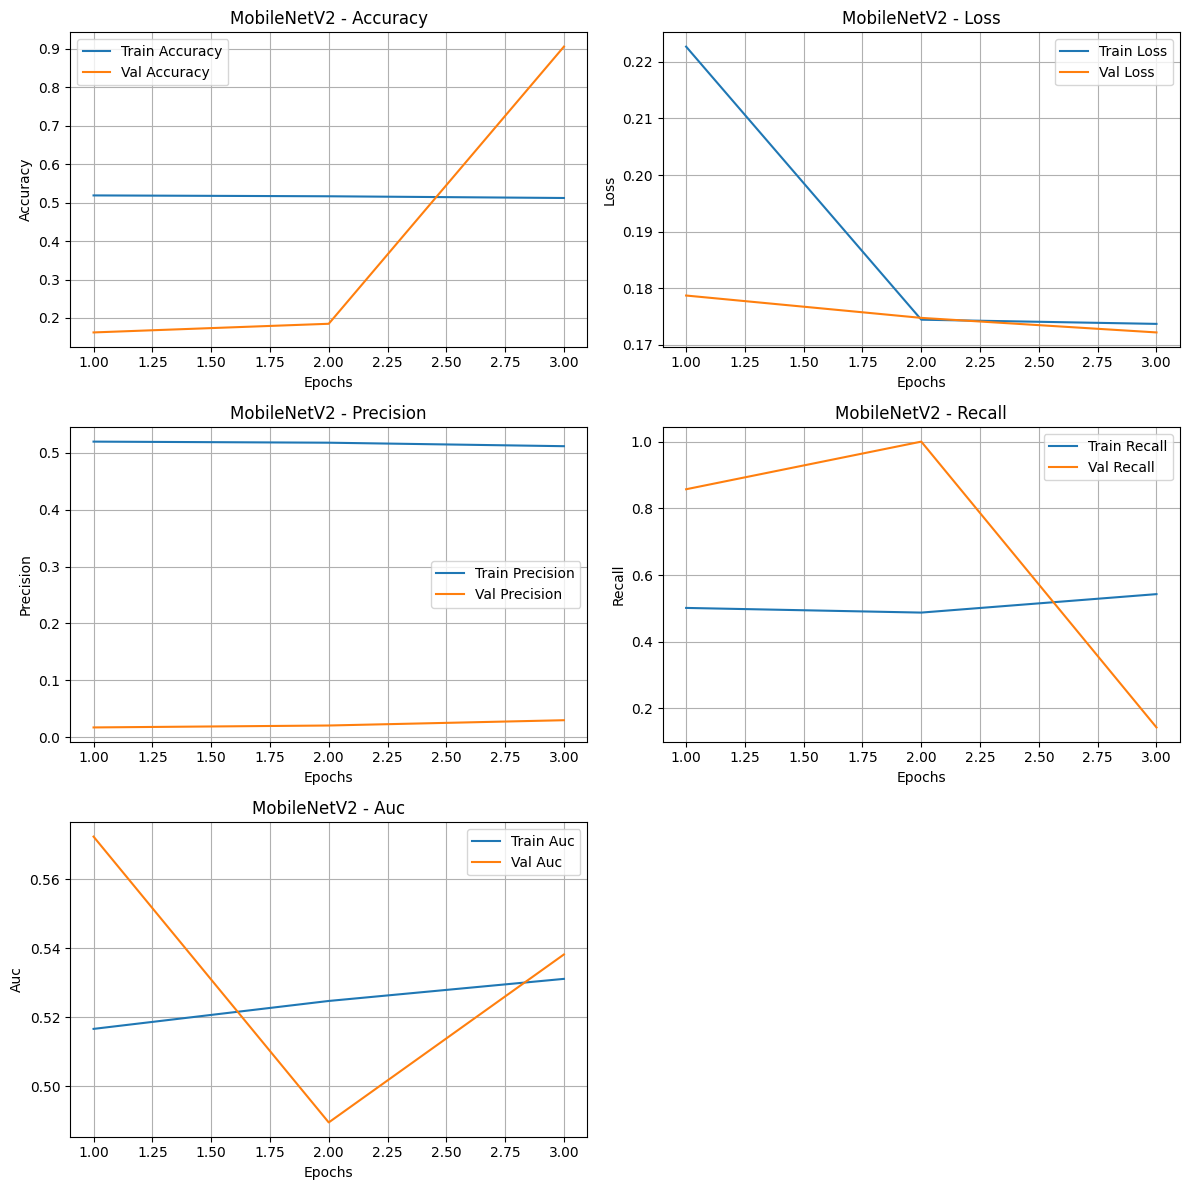

In [98]:
# plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
# plt.plot(history_mobilenet.history['val_accuracy'], label='Val Accuracy')
# plt.title('MobileNetV2 Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

plot_training_history(history_mobilenet, model_name="MobileNetV2")



## Model 2: EfficientNetB0

EfficientNetB0 is a state-of-the-art convolutional neural network architecture that balances high accuracy with computational efficiency. It uses a novel scaling method that adjusts width, depth, and resolution in a balanced way, making it well-suited for real-world applications like skin lesion classification on mobile devices.

- EfficientNetB0 trains slightly slower than MobileNetV2 but often achieves higher validation accuracy.
- Final model choice will be based on a trade-off between accuracy, speed, and mobile deployment feasibility.

In [99]:
# EfficientNetB0 base model setup
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze for feature extraction

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
# model.summary()


In [100]:
EPOCHS = 3 if FAST_MODE else 10

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True),
    ModelCheckpoint('efficientnetb0_skin_lesion.h5', save_best_only=True)
]

history_effnet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4924 - auc: 0.4774 - loss: 0.2019 - precision: 0.4824 - recall: 0.4850

99/99 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.4924 - auc: 0.4776 - loss: 0.2017 - precision: 0.4825 - recall: 0.4848 - val_accuracy: 0.9825 - val_auc: 0.5000 - val_loss: 0.1709 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.4892 - auc: 0.4860 - loss: 0.1734 - precision: 0.5016 - recall: 0.7688 - val_accuracy: 0.9825 - val_auc: 0.5000 - val_loss: 0.1732 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.4979 - auc: 0.4953 - loss: 0.1733 - precision: 0.5109 - recall: 0.1660 - val_accuracy: 0.9825 - val_auc: 0.5000 - val_loss: 0.1726 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


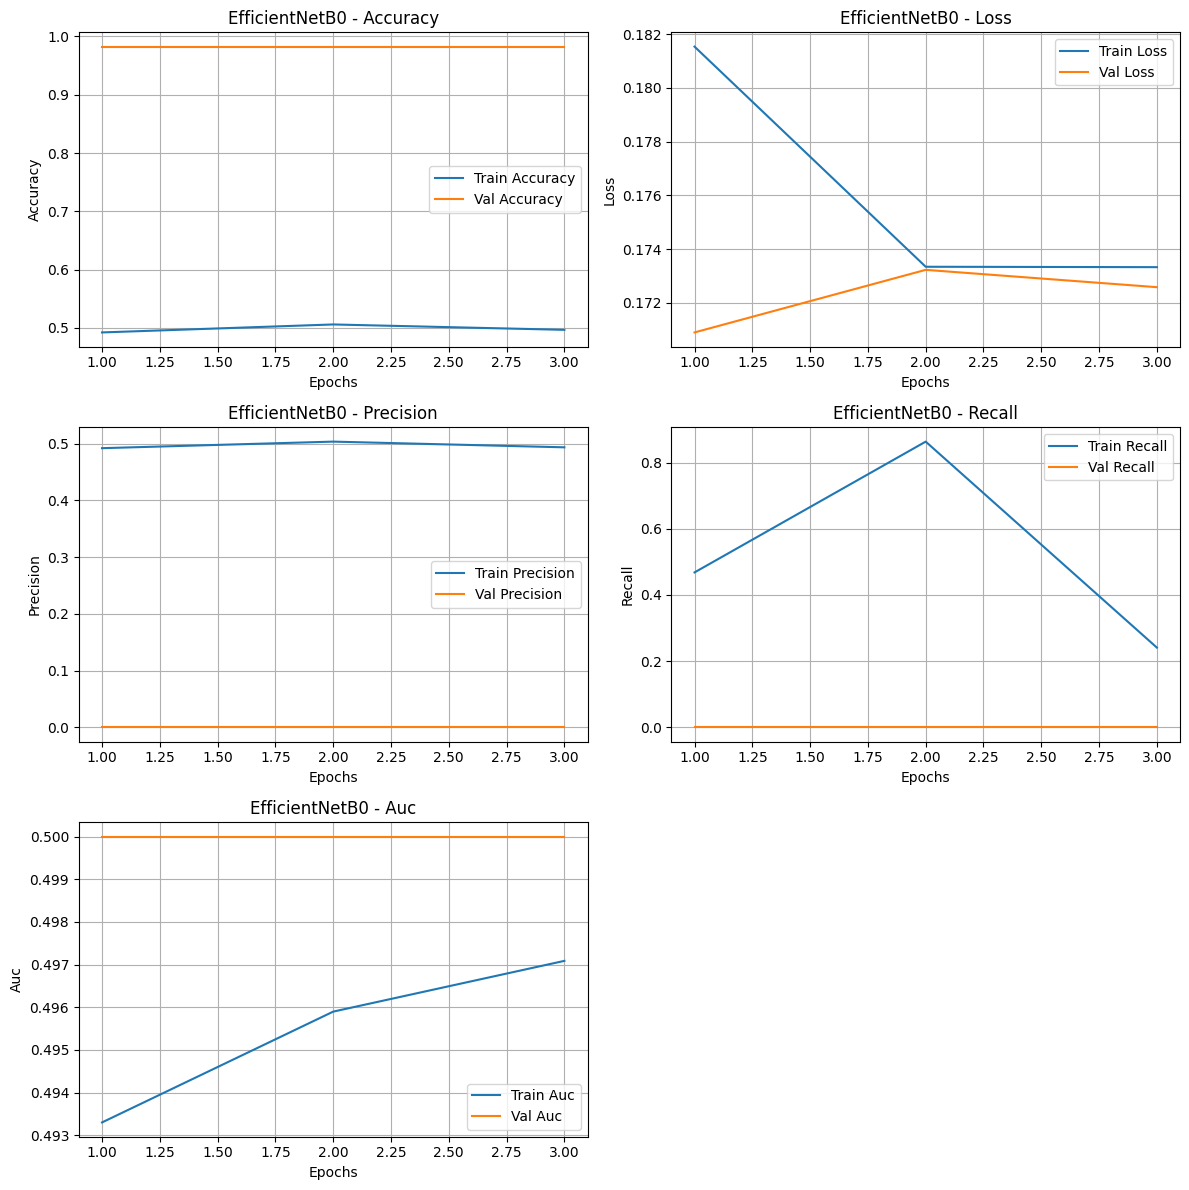

In [101]:
# plt.plot(history_effnet.history['accuracy'], label='Train Accuracy')
# plt.plot(history_effnet.history['val_accuracy'], label='Val Accuracy')
# plt.title('EfficientNetB0 Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
plot_training_history(history_effnet, model_name="EfficientNetB0")




## Model 3: ResNet50

ResNet50 (Residual Network) is a deep convolutional neural network that introduces **skip connections**, allowing the model to train very deep architectures without suffering from vanishing gradients. It’s widely used in medical image classification due to its high accuracy and stable training behavior.


In [102]:
# ResNet50 base model setup
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze for feature extraction

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
# model.summary()


In [103]:
EPOCHS = 3 if FAST_MODE else 10

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True),
    ModelCheckpoint('resnet50_skin_lesion.h5', save_best_only=True)
]

history_resnet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4908 - auc: 0.4855 - loss: 0.2458 - precision: 0.4754 - recall: 0.4794

99/99 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.4909 - auc: 0.4857 - loss: 0.2454 - precision: 0.4757 - recall: 0.4796 - val_accuracy: 0.0325 - val_auc: 0.5429 - val_loss: 0.1758 - val_precision: 0.0178 - val_recall: 1.0000
Epoch 2/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5182 - auc: 0.5222 - loss: 0.1757 - precision: 0.5309 - recall: 0.5984

99/99 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.5181 - auc: 0.5222 - loss: 0.1757 - precision: 0.5306 - recall: 0.5978 - val_accuracy: 0.9825 - val_auc: 0.5000 - val_loss: 0.1711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.5002 - auc: 0.4938 - loss: 0.1740 - precision: 0.4910 - recall: 0.3102 - val_accuracy: 0.0175 - val_auc: 0.5000 - val_loss: 0.1739 - val_precision: 0.0175 - val_recall: 1.0000


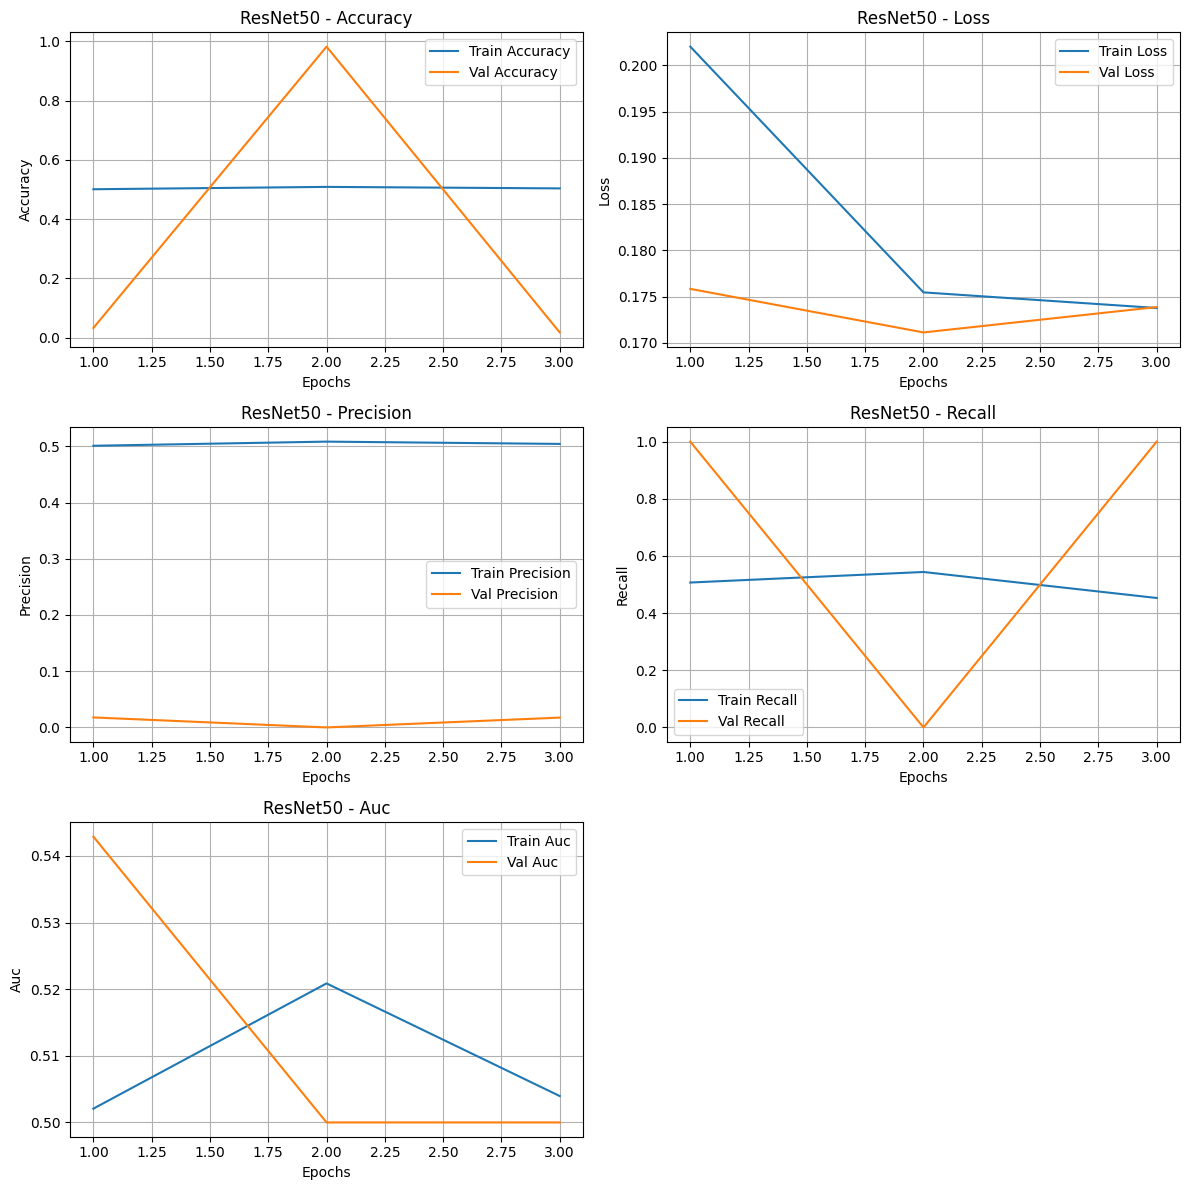

In [104]:
plot_training_history(history_resnet, model_name="ResNet50")


## Model 4: InceptionV3

InceptionV3 is a deep convolutional neural network that uses multiple filter sizes within the same layer, allowing it to learn both fine and coarse features. It was designed to achieve high accuracy while keeping computational cost manageable. InceptionV3 is particularly good for recognizing complex image patterns, making it suitable for medical image classification.


In [105]:
# InceptionV3 base model setup
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze for feature extraction

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
# model.summary()


In [106]:
EPOCHS = 3 if FAST_MODE else 10

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True),
    ModelCheckpoint('inceptionv3_skin_lesion.h5', save_best_only=True)
]

history_inception = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4782 - auc: 0.4795 - loss: 0.4027 - precision: 0.4726 - recall: 0.5603

99/99 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.4783 - auc: 0.4795 - loss: 0.4010 - precision: 0.4727 - recall: 0.5620 - val_accuracy: 0.0175 - val_auc: 0.4949 - val_loss: 0.1740 - val_precision: 0.0175 - val_recall: 1.0000
Epoch 2/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4804 - auc: 0.5096 - loss: 0.1734 - precision: 0.4712 - recall: 0.5907

99/99 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4803 - auc: 0.5095 - loss: 0.1734 - precision: 0.4712 - recall: 0.5888 - val_accuracy: 0.0175 - val_auc: 0.4987 - val_loss: 0.1739 - val_precision: 0.0175 - val_recall: 1.0000
Epoch 3/3
99/99 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.4949 - auc: 0.5028 - loss: 0.1733 - precision: 0.4950 - recall: 0.9902 - val_accuracy: 0.0175 - val_auc: 0.4975 - val_loss: 0.1744 - val_precision: 0.0175 - val_recall: 1.0000


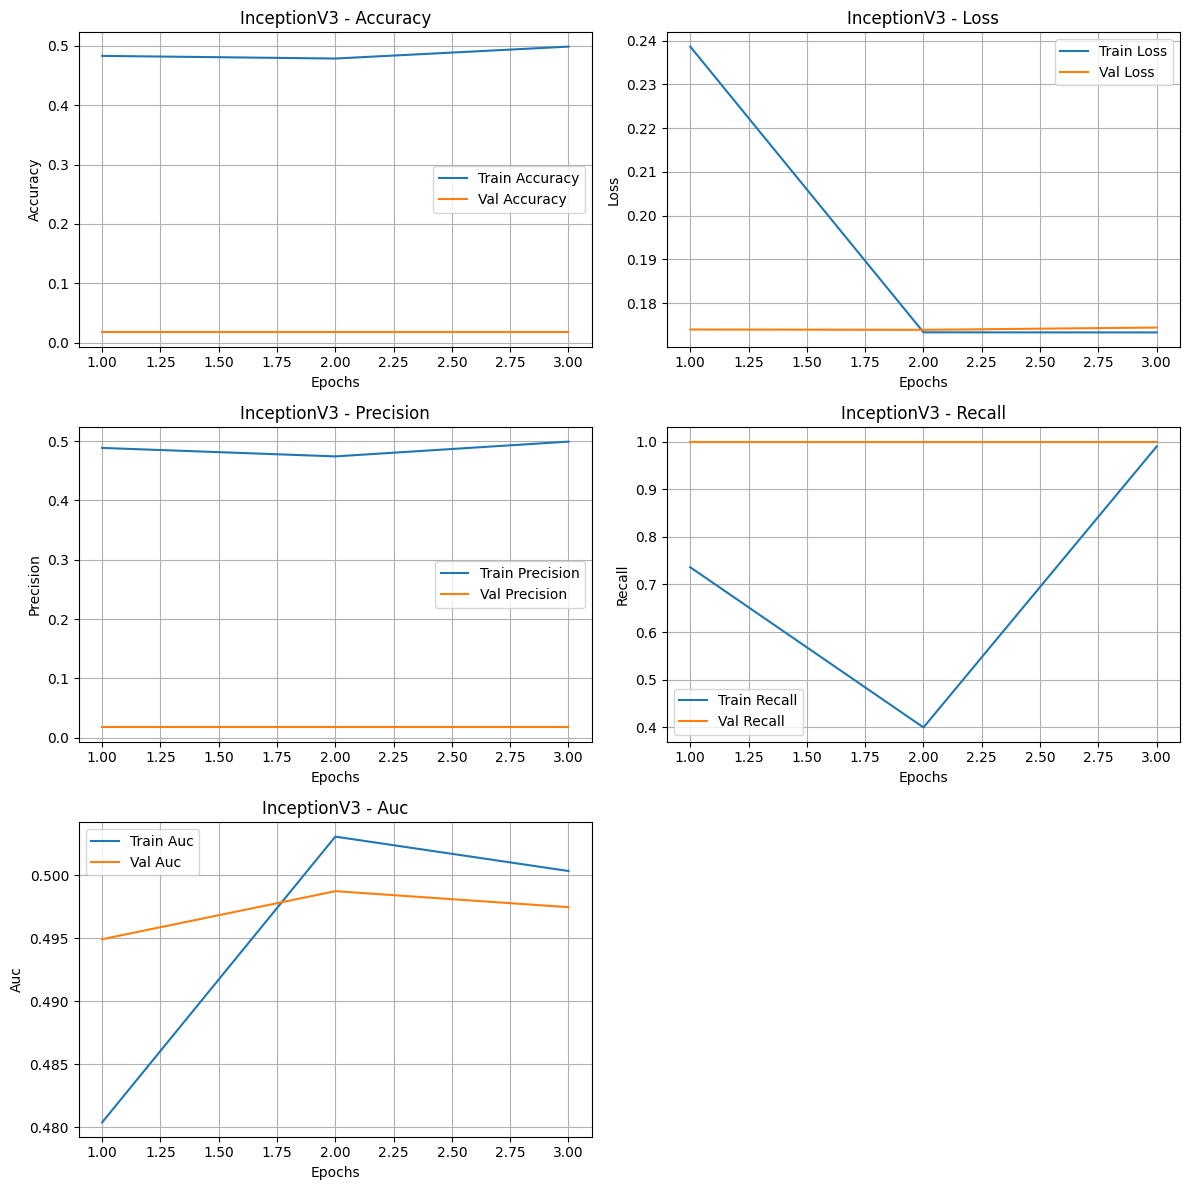

In [107]:
plot_training_history(history_inception, model_name="InceptionV3")


## Evaluation, Comparison, and Ranking

After training models, we evaluate their classification performance using standard metrics:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**
- **AUC (Area Under the ROC Curve)**

These metrics are calculated on the **validation dataset**, and used to compare model performance and rank the models objectively.


### Validation Accuracy Over Epochs

The plot below shows how each model's validation accuracy changed over training epochs. This helps identify which models learned efficiently, and which may have overfitted or plateaued early.


In [108]:
def plot_all_model_val_accuracy(histories):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy')
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_all_model_val_auc(histories):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        plt.plot(history.history['val_auc'], label=f'{name} Val Auc')
    
    plt.title('Validation AUC Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

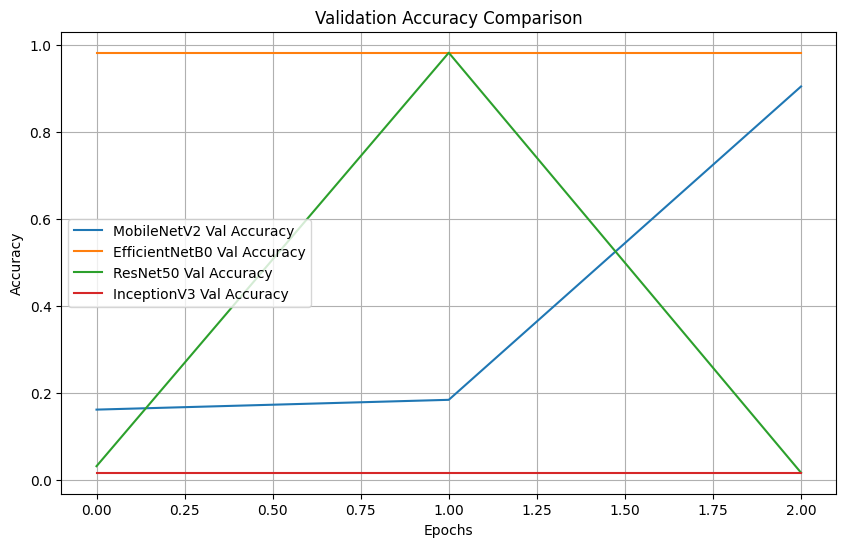

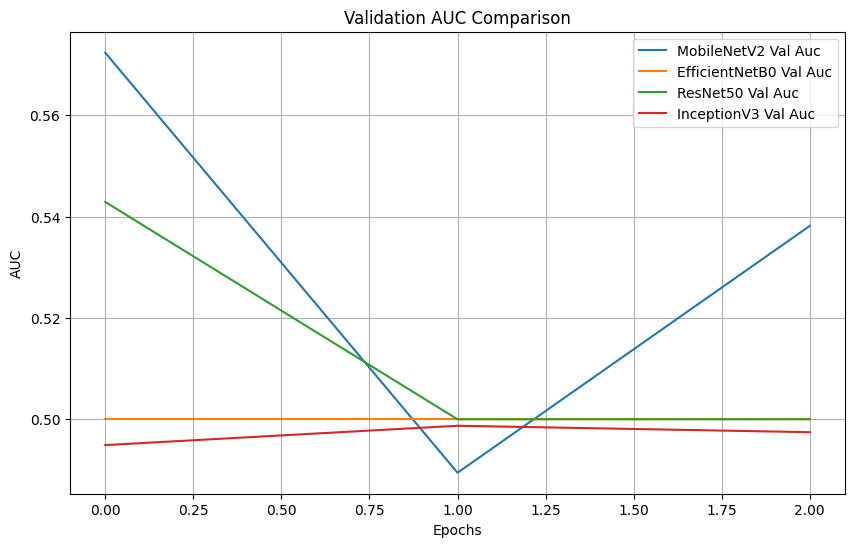

In [109]:
histories = {
    'MobileNetV2': history_mobilenet,
    'EfficientNetB0': history_effnet,
    'ResNet50': history_resnet,
    'InceptionV3': history_inception
}

plot_all_model_val_accuracy(histories)
plot_all_model_val_auc(histories)


### Evaluation Metrics Explained

- **Accuracy**: Proportion of total correct predictions
- **Precision**: Of the predicted positives, how many were correct
- **Recall**: Of all actual positives, how many were correctly predicted
- **F1-Score**: Balance between precision and recall
- **AUC**: Measures model’s ability to distinguish between classes

These metrics provide a comprehensive understanding of each model's strengths and weaknesses.


In [110]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred_probs = model.predict(generator, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)

    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc
    }


In [111]:
results = {
    'MobileNetV2': evaluate_model(tf.keras.models.load_model('mobilenetv2_skin_lesion.h5'), val_gen),
    'EfficientNetB0': evaluate_model(tf.keras.models.load_model('efficientnetb0_skin_lesion.h5'), val_gen),
    'ResNet50': evaluate_model(tf.keras.models.load_model('resnet50_skin_lesion.h5'), val_gen),
    'InceptionV3': evaluate_model(tf.keras.models.load_model('inceptionv3_skin_lesion.h5'), val_gen),
}


c:\Dissertation\SkinLesionClassifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Dissertation\SkinLesionClassifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Results Summary Table

The table below shows the performance of all models, sorted by **AUC**, which is often the most reliable metric for binary classification in medical datasets.


In [112]:
import pandas as pd

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='AUC', ascending=False)
results_df.style.set_caption("Model Performance Comparison (Validation Set)").format("{:.4f}")


,Accuracy,Precision,Recall,F1-Score,AUC
InceptionV3,0.0175,0.0175,1.0000,0.0344,0.5082
EfficientNetB0,0.9825,0.0000,0.0000,0.0000,0.5005
ResNet50,0.9825,0.0000,0.0000,0.0000,0.3581
MobileNetV2,0.9000,0.0000,0.0000,0.0000,0.2557


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# --- 1. Custom Focal Loss (no need for tensorflow-addons)
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.math.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.math.pow(y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy, axis=-1)
    return loss

# --- 2. MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

# --- 3. Compile
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# --- 4. Training
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', mode='max', patience=5, restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop],
    class_weight={0: 1.0, 1: 3.0},  # Balanced but not extreme
    verbose=1
)

# --- 5. Evaluation
y_probs = model.predict(val_gen)
y_true = val_gen.classes  # True labels from generator
threshold = 0.3  # 👈 You can experiment with this

y_pred = (y_probs > threshold).astype(int)

# --- 6. Custom metrics
print(f"AUC: {roc_auc_score(y_true, y_probs):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
